In [26]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [27]:
data = pd.read_csv("Ads_CTR_Optimisation.csv")
data.head()

,Ad 1,Ad 2,Ad 3,Ad 4,Ad 5,Ad 6,Ad 7,Ad 8,Ad 9,Ad 10
0,1,0,0,0,1,0,0,0,1,0
1,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0


## UCB 

In [28]:
def ucb_function(num_of_rounds, data):
    '''
        The Upper Confidence Bound function.
        
        Args:
            - num_of_rounds: how many rounds the function should run
            - data: the target data
        
        Return:
            - An array of the selected targets on each round
    '''
    
    # number of Ads
    d = len(data.columns)
    selected_ads = []
    num_of_each_ads_selection = [0] * d
    sum_of_rewards_for_each_ads = [0] * d
    total_rewards = 0

    for n in range(0, num_of_rounds):
        winner_ad = 0
        max_ucb = 0
        for i in range(0, d):
            if(num_of_each_ads_selection[i] > 0):
                average_reward = sum_of_rewards_for_each_ads[i] / num_of_each_ads_selection[i]
                delta_i = math.sqrt(3/2 * (math.log(n + 1) / num_of_each_ads_selection[i]))
                ucb = average_reward + delta_i
            else:
                # denominator in the average_reward equation is zero
                ucb = 1e400

            if ucb > max_ucb:
                max_ucb = ucb
                winner_ad = i

        selected_ads.append(winner_ad)
        num_of_each_ads_selection[winner_ad] += 1
        reward = data.values[n, winner_ad]
        sum_of_rewards_for_each_ads[winner_ad] += reward
        total_rewards += reward
    
    return selected_ads

- We run the UCB function multiple times with differnt round count
- We start with 100 rounds
- Each time we increase the number of rounds by 100
- The loop ends when the rounds earch the number of data records

The reason is that UCB is based on **exploration and exploitation**. This means in reality, we cannot expect to run the model for 10k (for all data records). We need to make a decision as soon as possible.

In [29]:
# number of users (rounds)
N_final = len(data)
initial_N = 100
step = 100
selected_ads_history = []
rounds = []
for N in range(initial_N, N_final + 1, step):
    selected_ads_history.append(ucb_function(N, data))
    rounds.append(N)

## Results

First, let's see which Ad was the most selected by UCB in overall (10k rounds) 

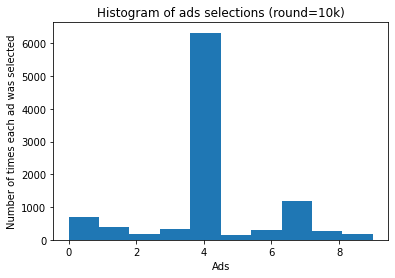

In [30]:
plt.hist(selected_ads_history[len(selected_ads_history) - 1])
plt.title('Histogram of ads selections (round=10k)')
plt.ylabel('Number of times each ad was selected')
plt.show()

Now, let's see which Ad was the most selected by UCB in initially for round==100

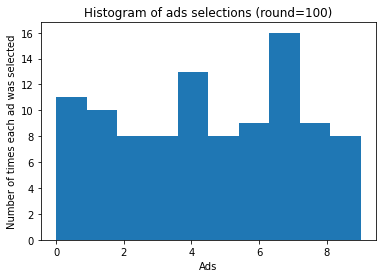

In [31]:
plt.hist(selected_ads_history[0])
plt.title('Histogram of ads selections (round=100)')
plt.xlabel('Ads')
plt.ylabel('Number of times each ad was selected')
plt.show()

- We can see that initially UCB picked the wrong Ad (7). Then it adjusted itself and picked the right one (4)
- Now let's see approximately on which round UCB understood the right Ad to pick

In [32]:
target_round_index = 0
for selected in selected_ads_history:
    picked_ad = int(list(stats.mode(selected))[0][0])
    if picked_ad != 4:
        target_round_index += 1
    else:
        break
        
rounds[target_round_index]

600

#### This means somewhere between round=500 and round=600 the model understood the right choice.